In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.idl import readsav
from scipy.signal import find_peaks
import pickle 
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
import numpy.ma as ma
from astropy.stats import sigma_clip
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
import mpl_toolkits.axes_grid1.axes_grid as axes_grid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from mpl_toolkits.axes_grid.colorbar import colorbar
from matplotlib.patches import Ellipse
import math
from matplotlib import cm
from astropy.wcs import WCS
import scipy
import scipy.ndimage as ndi
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import pkg_resources
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from __future__ import print_function
import pyspeckit
import pylab as pl

In [ ]:
def moment0(globule = 'GlobB', source = '13CO'):
    
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    data1 = data[0,:,:,:]
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    channels = np.arange(header["NAXIS3"])

    #define velocity as km/s blocks
    frequency = freq_start + (freq_inc * channels)
    frequency = np.array(frequency, dtype = float)
    
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    #print(vel_inc)
    
    if globule == 'GlobB':
        figure = plt.figure(figsize=[8, 8])
        x1 = round(header["CRPIX1"]-(ra_start-337.433)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(dec_start+20.812)/dec_inc)-2
    else:
        figure = plt.figure(figsize=[8, 8])
        x1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1
        
    print(x1, x2, y1, y2)
    print(x2-x1, y2-y1)
    
    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    integrated = np.sum(data3[:, :, :], axis = 0)*abs(vel_inc)
    
    #plt.imshow(integrated, origin = 'lower')
 
    max_val = np.nanmax(integrated)
    #print(max_val)
    
    if source == '12CO':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.03
    elif source == '13CO':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.1
    elif source == 'C18O':
        if globule == 'GlobB':
            d = 0.28
        else:
            d = 0.15
    elif source == 'CCH':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.15
    elif source == 'CCH_32':
        if globule == 'GlobB':
            d = 0.15
        else:
            d = 0.08
    elif source == 'HC3N':
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.25
    elif source == 'HCN':
        if globule == 'GlobB':
            d = 0.06
        else:
            d = 0.08
    elif source == 'HCN_32':
        if globule == 'GlobB':
            d = 0.065
        else:
            d = 0.04
    elif source == 'HCOp':
        if globule == 'GlobB':
            d = 0.08
        else:
            d = 0.1
    elif source == 'HCOp_32':
        if globule == 'GlobB':
            d = 0.1
        else:
            d = 0.08
    elif source == 'HNC':
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.08
    elif source == 'HNC_32':
        if globule == 'GlobB':
            d = 0.2
        else:
            d = 0.12
    
    integrated = np.sum(data3[:, :, :], axis = 0)

    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d*max_val:
            array.append(a[i])
    
    moment0 = np.sum(data3[array, :, :], axis = 0)
    
    #print(np.nanmax(data3))
    
    max_value = np.nanmax(moment0)
    #print(max_value)
    
    extent=[ra[x1],ra[x2],dec[y1],dec[y2]]
    
    #sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
    #newmask = (moment0 < np.amax(sigma_mask))
    
    mom0 = np.ma.array(moment0)*abs(vel_inc)
    maximum = np.nanmax(mom0)
    
    ax = figure.add_subplot(1, 1, 1)
    bmaj = header['BMAJ']#major beam width
    #print(bmaj)
    bmin = header['BMIN'] #minor beam width
    #print(bmin)
    bpa = header['BPA']
    beam = Ellipse(xy=(ra[x1 + 10], dec[y1 + 20]), width=bmaj, height=bmin, angle=bpa, color = 'white', zorder = 1)
    ax.add_artist(beam)
    #print(ra[40], dec[40])
    print(np.nanmax(mom0))
    
    plt.imshow(mom0, origin= 'lower', cmap='inferno', extent=extent, zorder = 0)
    #plt.imshow(mom0, origin= 'lower', cmap='hot', extent=extent, zorder = 0)

    plt.xticks()
    plt.yticks()
    #plt.set_facecolor("black")
    plt.xlabel('RA (deg)',fontsize=14)
    plt.ylabel('DEC (deg)',fontsize=14)
    plt.colorbar(label = r'Integrated Instensity (Jy/Beam km/s)', fraction=0.07, pad=0.04)
    plt.clim(0.0, maximum)

In [ ]:
def moment1(globule = 'GlobB', source = 'GlobB_CCH_32'):
    
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
   
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    if globule == 'GlobB':
        x1 = round(header["CRPIX1"]-(ra_start-337.434)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(dec_start+20.812)/dec_inc)-2
        plt.figure(figsize=[9,7])
    elif globule == 'GlobC':
        x1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1 
        x2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1 
        y1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1 
        y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1
        plt.figure(figsize=[7,9])
    
    #x = round(header["CRPIX1"]-(ra_start-337.397532)/ra_inc)-1
    #y = round(header["CRPIX2"]-(dec_start+20.797204)/dec_inc)-1
    
    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    freq_channels = np.arange(header["NAXIS3"])
    
    #box = 30
    data1 = data[0,:,:,:]
    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]
    
    integrated = np.sum(data3[:, :, :], axis = 0)
 
    max_val = np.nanmax(integrated)
    
    if source == '12CO':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.07
    elif source == '13CO':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.1
    elif source == 'C18O':
        if globule == 'GlobB':
            d = 0.28
        else:
            d = 0.15
    elif source == 'CCH':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.15
    elif source == 'CCH_32':
        if globule == 'GlobB':
            d = 0.15
        else:
            d = 0.08
    elif source == 'HC3N':
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.25
    elif source == 'HCN':
        if globule == 'GlobB':
            d = 0.06
        else:
            d = 0.08
    elif source == 'HCN_32':
        if globule == 'GlobB':
            d = 0.065
        else:
            d = 0.04
    elif source == 'HCOp':
        if globule == 'GlobB':
            d = 0.08
        else:
            d = 0.1
    elif source == 'HCOp_32':
        if globule == 'GlobB':
            d = 0.1
        else:
            d = 0.08
    elif source == 'HNC':
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.08
    elif source == 'HNC_32':
        if globule == 'GlobB':
            d = 0.2
        else:
            d = 0.12
    
    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d*max_val:
            array.append(a[i])
    print(array)
    array = [6, 7, 8]
    moment0 = np.sum(data3[array,:,:], axis=0)
    
    #define velocity as km/s blocks
    frequency = freq_start + (freq_inc * freq_channels)
    frequency = np.array(frequency, dtype = float)
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000
    
    #Go from Moment 0 to Moment 1
    intermediate = np.sum(data1[array,:,:] * velocity[array,np.newaxis,np.newaxis], axis=0)
    
    intermediate_x = intermediate[:, np.arange(x1, x2)]
    intermediate_y = intermediate_x[np.arange(y1, y2), :]
    moment1 = intermediate_y/moment0

    #Adding in the mask
    sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    #maskednoise = np.ma.masked_array(moment0, mask = newmask)
    
    mom1 = np.ma.array(moment1, mask=newmask)

    # Show Plot
    plt.imshow()
    plt.colorbar(label= 'Velocity (km/s)', fraction=0.075, pad=0.04)
    
    if globule == 'GlobB':
        plt.clim(-19, -15)
    elif globule == 'GlobC':
        plt.clim(-28.5, -27)
       
    plt.xticks()
    plt.yticks()
    plt.xlabel('RA (deg)',fontsize=14)
    plt.ylabel('DEC (deg)',fontsize=14)

In [ ]:
def plot_total_spectra(globule = 'GlobB', source = 'HCN'):
    
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    data1 = data[0,:,:,:]
    
    plt.figure(figsize=(8,5))
    
    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    freq_channels = np.arange(header["NAXIS3"])
    
    #define velocity as km/s blocks
    frequency = freq_start + (freq_inc * freq_channels)
    frequency = np.array(frequency, dtype = float)
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000
    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    
    rng=range(len(velocity))
    print(rng)
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    if globule == 'GlobB':
        x1 = round(header["CRPIX1"]-(ra_start-337.433)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.814)/dec_inc)-1
    elif globule == 'GlobC':
        x1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1
    
    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    spectrum = []
    for i in rng:
        spectrum += [np.nansum(data1[i, :, :])]
    
    plt.plot(velocity, spectrum, label = 'Spectrum')
    
    #plt.title('Intensity Spectrum for ' + source, fontsize = 16)
    plt.xlabel('Velocity km/s')
    plt.ylabel('Intensity (K km/s)')
    plt.xticks()
    plt.yticks()
    plt.legend()
    plt.grid()

In [10]:
def pos_vel(globule = 'GlobB', source = '13CO'):
    
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    data1 = data[0,:,:,:]

    plt.figure(figsize=[4,8]) #Globule B
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - (header["CRPIX1"])+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - (header["CRPIX2"])+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]
    
    freq_channels = np.arange(header["NAXIS3"])
    
    frequency = freq_start + (freq_inc * freq_channels)
    frequency = np.array(frequency, dtype = float)
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000
    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    #print(velocity)
    
    if globule == 'GlobB':
        figure = plt.figure(figsize=[8, 10])
        x1 = round(header["CRPIX1"]-(ra_start-337.434)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(dec_start+20.812)/dec_inc)-2
    else:
        figure = plt.figure(figsize=[8, 10])
        x1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1
    
    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    integrated = np.sum(data3[:, :, :], axis = 0)*abs(vel_inc)
    
    #plt.imshow(integrated, origin = 'lower')
 
    max_val = np.nanmax(integrated)
    #print(max_val)
    
    if source == '12CO':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.03
    elif source == '13CO':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.1
    elif source == 'C18O':
        if globule == 'GlobB':
            d = 0.28
        else:
            d = 0.15
    elif source == 'CCH':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.15
    elif source == 'CCH_32':
        if globule == 'GlobB':
            d = 0.15
        else:
            d = 0.08
    elif source == 'HC3N':
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.25
    elif source == 'HCN':
        if globule == 'GlobB':
            d = 0.06
        else:
            d = 0.08
    elif source == 'HCN_32':
        if globule == 'GlobB':
            d = 0.065
        else:
            d = 0.04
    elif source == 'HCOp':
        if globule == 'GlobB':
            d = 0.08
        else:
            d = 0.1
    elif source == 'HCOp_32':
        if globule == 'GlobB':
            d = 0.1
        else:
            d = 0.08
    elif source == 'HNC':
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.08
    elif source == 'HNC_32':
        if globule == 'GlobB':
            d = 0.2
        else:
            d = 0.12
    
    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)

    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d*max_val:
            array.append(a[i])
            
    array = [23, 24, 25, 26, 27, 28]
            
    print(array)
    
    integrated = np.nansum(data3[array, :, :], axis = 2)
    #print(integrated.shape)
    
    extent = [velocity[array[-1]], velocity[array[0]], dec[y1], dec[y2]]
    
    tr = scipy.ndimage.rotate(integrated, 270)

    levels = np.linspace(0, np.nanmax(integrated), 15)
    plt.contour(tr, levels = levels[1:15], cmap = 'afmhot', origin = 'lower', extent = extent)
    
    #plt.text(25, 10, 'source')
   
    plt.xticks()
    plt.yticks()
    plt.xlim(velocity[array[-1]], velocity[array[0]])
    plt.xlabel('Velocity (km/s)',fontsize=14)
    plt.ylabel('DEC (deg)',fontsize=14)
    #plt.legend(loc='upper right')
    plt.colorbar(label = r'Integrated Instensity ($\mathrm{K\,kms^{-1}}$)', fraction=0.048, pad=0.04)

[23, 24, 25, 26, 27, 28]


<Figure size 288x576 with 0 Axes>

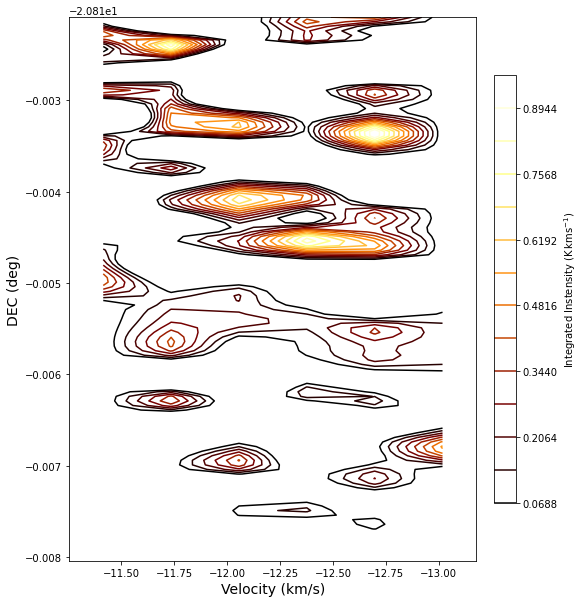

In [11]:
pos_vel(globule = 'GlobB', source = '13CO')